#### Student Name:

---


#### Student ID:


## Overview
### Due December 1st

Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in individually, you can collaborate with one classmate.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

After completing the assignment, please submit this notebook. YOU MUST SUBMIT EACH HOMEWORK, even if your partner submits!

Upload your completed assignment on moodle.

In [11]:
# If you're collaboraing with a classmate, please fill in the following:

collaboration = {
    "322216128" : "319046611"
}

In [12]:
! pip install librosa

In [13]:
import librosa
print(librosa.version)

<module 'librosa.version' from '/opt/anaconda3/lib/python3.11/site-packages/librosa/version.py'>


# Understanding Sound

For this portion of the assignment, you will load your unique wav file from
https://drive.google.com/drive/folders/122l65r1FZcHyRt4bfjIi4HRg_mVLKc1T?usp=sharing

Please enter your first and last name, like below, to get the name of your audio file.


In [14]:
your_firstname = "Neta"
your_lastname = "Nakdimon"
print(f"{your_firstname[0]}.{your_lastname}.wav")

N.Nakdimon.wav


Your task is to listen and examine your file and try to recreate it with sin waves.

Hints :)
- The length of each frequency used is 3-7 seconds
- Each frequency is set to start at exactly the start of a second
- The amplitudes used are [0.5, 1, 1.5, 2, 2.5]
- Think of all we learned in class (sample rate, wave forms, adding waves, spectrogram, etc.)
- These may be helpful for you
 - http://librosa.org/doc/0.8.1/generated/librosa.display.waveplot.html
  - https://librosa.org/doc/main/generated/librosa.stft.html

In [15]:
import librosa
import librosa.display as dsp
import pandas as pd

from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np

### Modify the line below with your WAV file:
y, sample_rate = librosa.load("/Users/netanakdimon/Desktop/SignalProcessing/Ex1/N.Nakdimon.wav")

Audio(data=y,rate=sample_rate)

##### Question 1 [15 points]
Reconstruct your wav file using sin waves. Use whatever approach you can think of. Google is your friend if you need it.

Make sure to play your version and also show the difference between the original and your reconstruction.

In [16]:
# Each frequency lasts for 3-7 seconds
# Frequencies always start at the beginning of a second
# Possible amplitude values are [0.5, 1, 1.5, 2, 2.5]

# Total duration of the audio in seconds
audio_duration = int(len(y) / sample_rate)

# Window duration for analysis (1 second per window)
window_duration = 1

# Frequency bins for the audio signal
frequency_bins = np.fft.rfftfreq(sample_rate, d=1. / sample_rate)


def generate_sine_wave(frequency, amplitude, duration, sample_rate):
    """
    Generate a sine wave for a given frequency, amplitude, and duration.

    Args:
        frequency (float): Frequency of the sine wave in Hz.
        amplitude (float): Amplitude of the sine wave.
        duration (float): Duration of the sine wave in seconds.
        sample_rate (int): Sampling rate of the audio.

    Returns:
        np.array: The generated sine wave.
    """
    time_axis = np.arange(0, duration, 1 / sample_rate)
    return amplitude * np.sin(2 * np.pi * frequency * time_axis)


def find_active_intervals(amplitude_array, min_duration=3, max_duration=7):
    """
    Identify continuous intervals where a frequency is active within specified durations.

    Args:
        amplitude_array (list): Array of amplitudes for a specific frequency over time.
        min_duration (int): Minimum duration (in frames) for a valid interval.
        max_duration (int): Maximum duration (in frames) for a valid interval.

    Returns:
        dict: A dictionary mapping start indices to end indices of valid intervals.
    """
    active_count = 0
    max_active_count = 0
    intervals = {}
    interval_start, interval_end = 0, 0

    for idx, amplitude in enumerate(amplitude_array):
        if amplitude > 0:
            active_count += 1
            if active_count == 1:  # First frame in a new active interval
                interval_start = idx
            interval_end = idx
            if active_count > max_active_count:
                max_active_count = active_count
                if max_duration >= max_active_count >= min_duration:
                    intervals[interval_start] = interval_end
        else:
            active_count = 0
            max_active_count = 0

    return intervals


def compute_fft_spectrum(signal, total_duration, sample_rate):
    """
    Compute the FFT spectrum for the signal over 1-second windows.

    Args:
        signal (np.array): Input audio signal.
        total_duration (int): Total duration of the signal in seconds.
        sample_rate (int): Sampling rate of the audio.

    Returns:
        np.array: A complex matrix representing frequencies vs time windows.
    """
    spectrum_matrix = []

    for second in range(total_duration):
        segment = signal[second * sample_rate: (second + 1) * sample_rate] #Extract segment from signal
        fft_result = np.fft.rfft(segment)
        spectrum_matrix.append(fft_result)

    return np.array(spectrum_matrix).T


def filter_frequencies(frequencies, amplitude_matrix):
    """
    Filter frequencies based on the duration of their activity.

    Args:
        frequencies (np.array): Array of frequency values.
        amplitude_matrix (pd.DataFrame): DataFrame of amplitude values over time.

    Returns:
        pd.DataFrame: DataFrame with filtered frequency bins and their active intervals.
    """
    frequency_intervals = {}

    for freq_index, amplitude_column in amplitude_matrix.iterrows():
        intervals = find_active_intervals(amplitude_column, min_duration=3, max_duration=7)
        if intervals:
            frequency_intervals[frequencies[freq_index]] = intervals

    result_df = pd.DataFrame(frequency_intervals.keys(), columns=["frequency_bin"])
    result_df["intervals"] = frequency_intervals.values()

    return result_df


def reconstruct_audio(signal, sample_rate):
    """
    Reconstruct an audio signal using sine waves.

    Args:
        signal (np.array): Original audio signal.
        sample_rate (int): Sampling rate of the audio.

    Returns:
        tuple: Reconstructed signal, frequency DataFrame, and amplitude matrix.
    """
    audio_length = int(len(signal) / sample_rate)
    reconstructed_audio = np.zeros_like(signal)
    amplitude_options = [0.5, 1, 1.5, 2, 2.5]
    frequency_bins = np.fft.rfftfreq(sample_rate, d=1. / sample_rate)

    fft_matrix = compute_fft_spectrum(signal, audio_length, sample_rate)
    amplitude_matrix = pd.DataFrame(np.abs(fft_matrix).round(1))
    filtered_frequencies = filter_frequencies(frequency_bins, amplitude_matrix)

    for _, row in filtered_frequencies.iterrows():
        frequency = row["frequency_bin"]
        start_indices, end_indices = list(row["intervals"].keys()), list(row["intervals"].values())

        for start, end in zip(start_indices, end_indices):
            for frame in range(start, end + 1):
                amplitude = np.abs(fft_matrix[int(frequency), int(frame)])
                sine_wave = generate_sine_wave(frequency, amplitude, window_duration, sample_rate)
                reconstructed_audio[frame * sample_rate: (frame + 1) * sample_rate] += sine_wave

    return reconstructed_audio, filtered_frequencies, fft_matrix

In [17]:
reconstructed_waveform, filtered_frequencies, fft_matrix = reconstruct_audio(y, sample_rate)

In [18]:
#Print frequent frequencies 
filtered_frequencies

frequency_bin intervals
0          231.0  {11: 13}
1          526.0  {11: 15}
2          573.0    {0: 6}
3          711.0   {8: 13}
4         2393.0    {0: 6}
5         3551.0   {6: 10}
6         3721.0   {6: 11}

### Plot the original and reconstucted signals

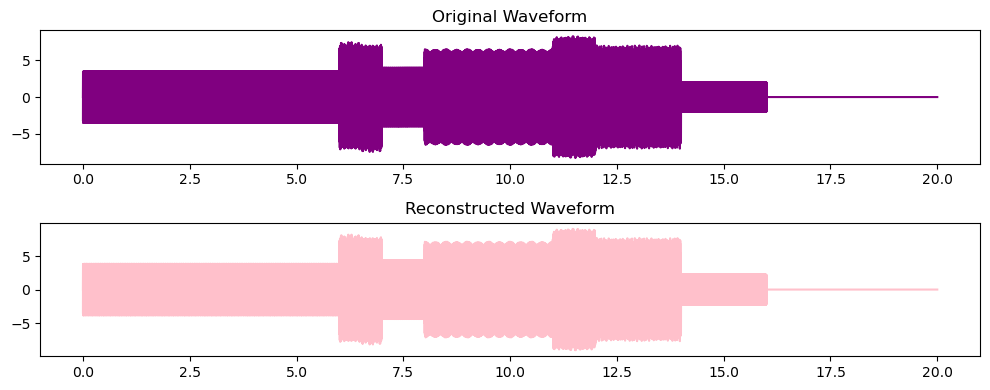

In [19]:
# Plot and compare the original and reconstructed waveforms
def plot_signals(y, reconstruct_audio, audio_duration, sample_rate):
  time = np.arange(0, audio_duration, 1/sample_rate)
  plt.figure(figsize=(10, 4))
  plt.subplot(2, 1, 1)
  plt.plot(time, y, label='Original', color="purple")
  plt.title('Original Waveform')
  plt.subplot(2, 1, 2)
  plt.plot(time, reconstruct_audio, label='Reconstructed', color='pink')
  plt.title('Reconstructed Waveform')
  plt.tight_layout()
  plt.show()

y_hat = reconstructed_waveform*1e-4
plot_signals(y, y_hat, audio_duration, sample_rate)

### Play the original and reconstucted signals

In [20]:
print ("Orginial signal")
display(Audio(y, rate=sample_rate))
print("Reconstructed signal")
display(Audio(reconstructed_waveform, rate=sample_rate))


Orginial signal


Reconstructed signal


### Plot the signals' difference

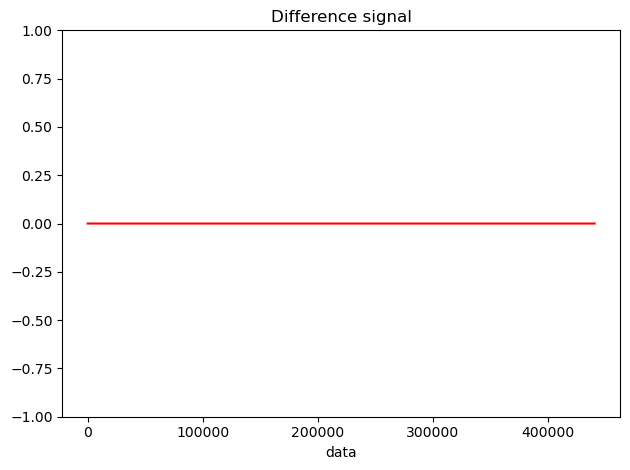

In [21]:
def plot_signals_diff(y_norm, y_hat_norm):
  z = np.abs(y_norm - y_hat_norm)

  plt.title("Difference signal")
  plt.plot(z, 'r')
  plt.xlabel("data")
  plt.ylim([-1, 1])
  plt.tight_layout()
  plt.show()

y_norm = y/np.abs(y).max()
y_hat_norm = y_hat/np.abs(y_hat).max()
plot_signals_diff(y_norm, y_hat_norm)

##### Question 2 [10 points]
Explain the logic you used to reconstruct the wav file. How did you find the frequencies? How did you figure out where they start and end?
How well did you do?

```Your Answer Here```

##### Question 3 [15 points]
Show some of your work on how you reconstructed the wav file. Show some actual code you used in understanding what the file is composed of? Visuals are nice.

In [22]:
"""Your Code Here"""

'Your Code Here'

##### Question 4 [15 points]
Resample your file so that only three or four different frequencies remain. Resample down and then back up to the original sample rate.

Hint:
- https://librosa.org/doc/main/generated/librosa.resample.html
- How can we see the frequencies?
- What is the relationship between the sample rate and the maximum frequency detectable?

In [23]:
def get_filtered_matrix(mat, df):
    # Initialize a list to store selected frequencies
    selected_frequencies = []

    # Create a new matrix with the same shape as the original, filled with zeros
    filtered_matrix = np.zeros_like(mat)

    # Loop over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the frequency value from the DataFrame row
        frequency = row["frequency_bin"]
        selected_frequencies.append(frequency)

        # Extract the start and end indices for this frequency
        start_indices, end_indices = list(row["intervals"].keys()), list(row["intervals"].values())

        # Loop over each start-end index pair
        for start, end in zip(start_indices, end_indices):
            # Copy the relevant portion from the original matrix to the filtered matrix
            filtered_matrix[int(frequency), start:end+1] = mat[int(frequency), start:end+1]

    # Return the filtered matrix
    return filtered_matrix

In [24]:
def analyze_resampled_signal(resampled_signal, resampled_sample_rate, original_unique_freqs, plot_title=""):
    # Reconstruct the waveform for the resampled signal
    reconstructed_waveform_resampled, df_resampled, mat_resampled = reconstruct_audio(resampled_signal, resampled_sample_rate)
    
    # Calculate the frequency bins for the resampled signal
    resampled_freqs = np.fft.rfftfreq(resampled_sample_rate, d=1./resampled_sample_rate) 
    
    # Apply filtering to the matrix of frequency data
    filtered_matrix = get_filtered_matrix(mat_resampled, df_resampled)

    # Find the intersection of frequencies between the original and resampled signals
    common_frequencies = set(original_unique_freqs).intersection(set(df_resampled.frequency_bin.values))
    print("Common frequencies between original and resampled signals are:", common_frequencies)

    # Create a masked matrix that includes only the common frequencies
    masked_matrix = np.zeros_like(filtered_matrix)
    freq_indices = np.array(list(common_frequencies)).astype(int)
    masked_matrix[freq_indices, :] = filtered_matrix[freq_indices, :]

    
    return common_frequencies

### ReSample Down

In [25]:
# Set the new sample rate as 1/5th of the original sample rate
new_sample_rate = int(sample_rate / 5)

# Print the original and downsampled sample rates
print(f"Initial Sample Rate: {sample_rate}, Resampled Sample Rate: {new_sample_rate}")

# Resample the original signal to the new sample rate
downsampled_signal = librosa.resample(y, orig_sr=sample_rate, target_sr=new_sample_rate)

# Print the number of samples before and after downsampling
print(f"Initial number of samples: {len(y)}, Downsampled number of samples: {len(downsampled_signal)}")

# Print the duration of the original and downsampled signals
print(f"Original signal duration: {len(y) / sample_rate} seconds, Downsampled signal duration: {len(downsampled_signal) / new_sample_rate} seconds")

Initial Sample Rate: 22050, Resampled Sample Rate: 4410
Initial number of samples: 441000, Downsampled number of samples: 88200
Original signal duration: 20.0 seconds, Downsampled signal duration: 20.0 seconds


In [26]:
# Analyze the downsampled signal by passing in the downsampled signal, its sample rate, and the unique frequencies from the dataframe
downsampled_unique_freqs = analyze_resampled_signal(downsampled_signal, new_sample_rate, set(filtered_frequencies.frequency_bin.values), plot_title=": Downsampled Signal")


Common frequencies between original and resampled signals are: {231.0, 573.0, 526.0, 711.0}


### ReSample Up

In [27]:
# Resample the downsampled signal back to the original sample rate
restored_signal = librosa.resample(downsampled_signal, orig_sr=new_sample_rate, target_sr=sample_rate)

# Print the shape of the resampled back signal and the original signal in terms of blocks of 20 samples
print(f"Resampled back signal shape (in blocks of 20 samples): {restored_signal.shape[0] / 20}, Original signal shape (in blocks of 20 samples): {y.shape[0] / 20}")

# Analyze the resampled signal by passing in the restored signal, original sample rate, and unique frequencies from the resampled signal
unique_frequencies_after_resampling = analyze_resampled_signal(restored_signal, sample_rate, downsampled_unique_freqs, plot_title=": Restored Signal")


Resampled back signal shape (in blocks of 20 samples): 22050.0, Original signal shape (in blocks of 20 samples): 22050.0
Common frequencies between original and resampled signals are: {711.0, 573.0, 526.0, 231.0}


##### Question 5 [15 points]
Generate phase for your file using GriffinLim.
Show the following:
- Your waveform after stft and then istft
- Your waveform after 0 iteration of GL
- Your waveform after GL
- The difference between the original and the 0 iter version
- The difference between the original and the GM version
- The difference between the original and the stft-istft version
 - Note that doing STFT and back looses some information so you may need to crop your original vector to match the sizes

Hint:
- https://librosa.org/doc/main/generated/librosa.griffinlim.html
- How can we see the frequencies?
- What is the relationship between the sample rate and the maximum frequency detectable?

In [28]:


# Calculate the Short-Time Fourier Transform 
spectrogram = librosa.stft(y)

# Reconstruct the signal from its STFT using the inverse STFT
reconstructed_signal_istft = librosa.istft(spectrogram, length=len(y))

# Extract the magnitude spectrogram
magnitude_spectrogram = np.abs(spectrogram)

# Griffin-Lim algorithm for phase recovery with zero iterations
reconstructed_signal_0_iter_gl = librosa.griffinlim(magnitude_spectrogram, n_iter=0)

# Griffin-Lim algorithm with full iterations for a better reconstruction
reconstructed_signal_full_gl = librosa.griffinlim(magnitude_spectrogram)


In [29]:
Audio(data=reconstructed_signal_0_iter_gl,rate=sample_rate)

In [30]:
Audio(data=reconstructed_signal_full_gl,rate=sample_rate)

In [31]:
Audio(data=reconstructed_signal_istft,rate=sample_rate)

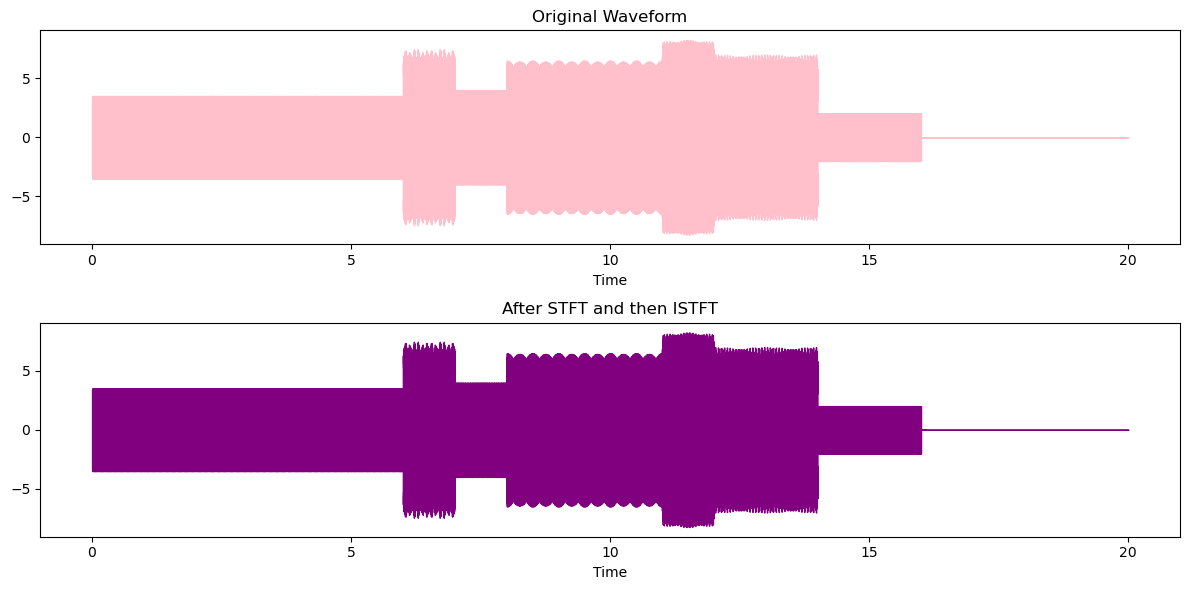

In [41]:

fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot the original waveform
librosa.display.waveshow(y, sr=sample_rate, ax=axes[0], color = 'pink')
axes[0].set_title('Original Waveform')

# Plot the waveform after STFT and ISTFT
librosa.display.waveshow(reconstructed_signal_istft, sr=sample_rate, ax=axes[1], color= 'purple')
axes[1].set_title('After STFT and then ISTFT')


fig.tight_layout()
plt.show()

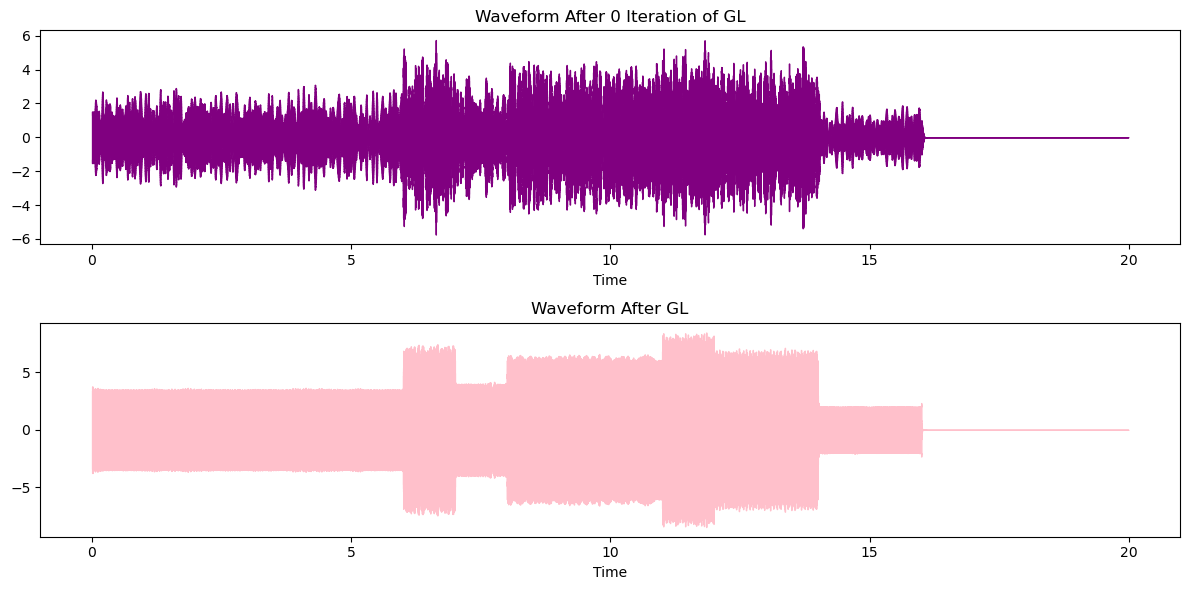

In [39]:


fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot the waveform after 0 iteration of GL
librosa.display.waveshow(reconstructed_signal_0_iter_gl, sr=sample_rate, ax=axes[0], color='purple')
axes[0].set_title('Waveform After 0 Iteration of GL')

# Plot the waveform after full GL
librosa.display.waveshow(reconstructed_signal_full_gl, sr=sample_rate, ax=axes[1], color='pink')
axes[1].set_title('Waveform After GL')


fig.tight_layout()
plt.show()

### The Diffrences

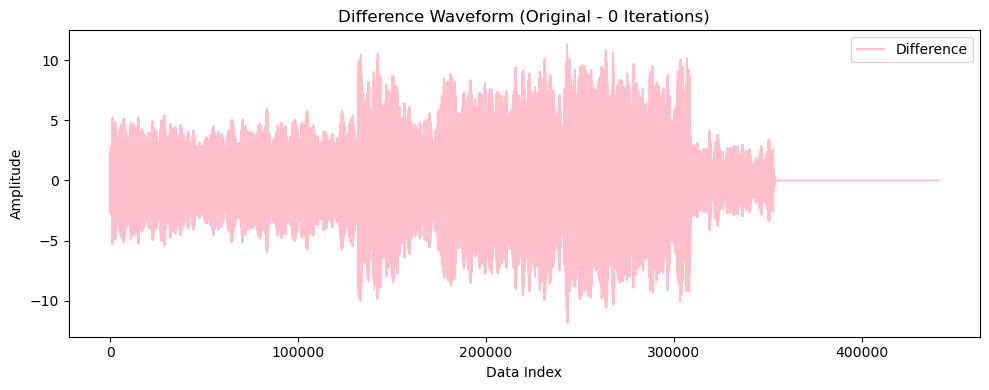

In [36]:
# Ensure the original signal matches the length of the reconstructed waveform
adjusted_length_y = y[:len(reconstructed_signal_0_iter_gl)]

# Calculate the difference waveform
difference_waveform = adjusted_length_y - reconstructed_signal_0_iter_gl

# Plot the difference waveform
plt.figure(figsize=(10, 4))
plt.plot(difference_waveform, color='pink', label='Difference')
plt.xlabel('Data Index')
plt.ylabel('Amplitude')
plt.title('Difference Waveform (Original - 0 Iterations)')
plt.legend()
plt.tight_layout()
plt.show()


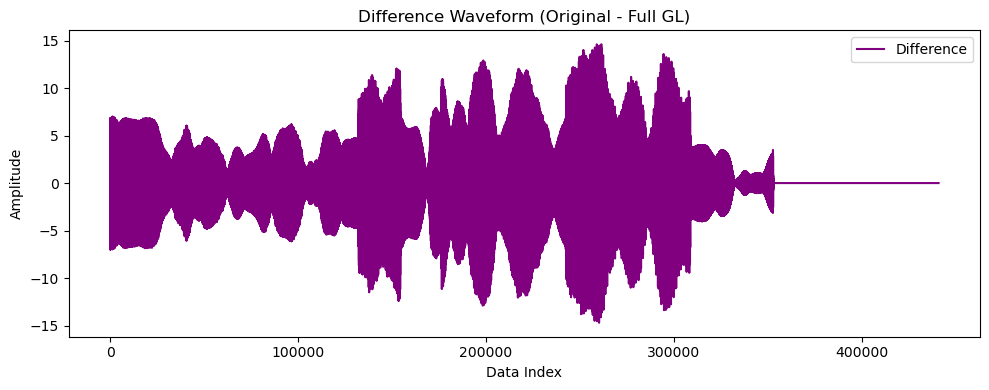

In [40]:
# Match the length of the original signal to the GL-reconstructed version
adjusted_length_y = y[:len(reconstructed_signal_full_gl)]

# Calculate the difference waveform
difference_waveform = adjusted_length_y - reconstructed_signal_full_gl

# Plot the difference waveform
plt.figure(figsize=(10, 4))
plt.plot(difference_waveform, color='purple', label='Difference')
plt.xlabel('Data Index')
plt.ylabel('Amplitude')
plt.title('Difference Waveform (Original - Full GL)')
plt.legend()
plt.tight_layout()
plt.show()


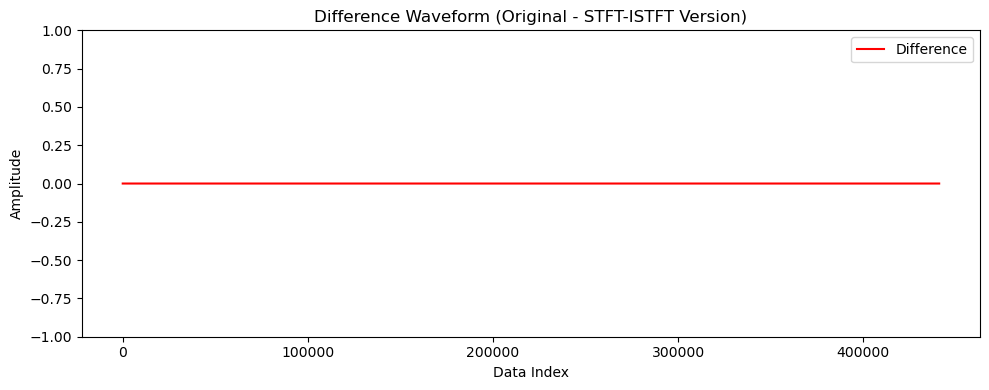

In [43]:
# Calculate the difference waveform between the original and STFT-ISTFT version
difference_waveform = y - reconstructed_signal_istft

# Plot the difference waveform
plt.figure(figsize=(10, 4))
plt.plot(difference_waveform, color='red', label='Difference')
plt.xlabel('Data Index')
plt.ylabel('Amplitude')
plt.ylim([-1, 1])  # Limit the y-axis to emphasize small differences
plt.title('Difference Waveform (Original - STFT-ISTFT Version)')
plt.legend()
plt.tight_layout()
plt.show()


##### Question 6 [10 points]

Describe the difference between the Griffith & Lim and the perfect reconstruction. Does it sound similar? Can you see the difference in the waveform?

The Griffin-Lim algorithm uses an iterative approach to estimate the phase, which can introduce phase inaccuracies. In contrast, perfect reconstruction assumes the original phase is preserved exactly, enabling flawless reconstruction without the need for iterative adjustments. While Griffin-Lim refines the phase estimate through repeated optimization steps until convergence, perfect reconstruction bypasses this process entirely since no phase estimation is required.
Despite sounding nearly identical, the Griffin-Lim reconstruction, even when missing 1 second, shows noticeable differences in the waveform. As seen in the graphs, the Griffin-Lim version displays more irregularities, such as spikes and small discontinuities, due to the imperfections in its phase estimation process.

##### Question 7 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 6.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.

```Your Answer Here```